### This notebook has to be run on Google colab

<a target="_blank" href="https://colab.research.google.com/github/pbuslaev/test_ipynb/blob/main/test_user_input.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title Conda installation
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
#@title Intall packages
!pip install dimorphite_dl --upgrade
!mamba install -c conda-forge rdkit sympy openff-toolkit

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.0 MB/s eta 0:00:00
  Created wheel for dimorphite_dl: filename=dimorphite_dl-1.3.2-py3-none-any.whl size=16867 sha256=6d1a0631315638da1a0a2b5848ecb6847b0307d45abed8848a6c366cc7444905
  Stored in directory: /root/.cache/pip/wheels/61/49/66/d58266747837b243c5495f897daaa3ee4f4dc6115755a9ef72
Successfully built dimorphite_dl

Looking for: ['rdkit', 'sympy']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch    15%[+] 0.3s
conda-forge/linux-64   5%
conda-forge/noarch    39%[+] 0.4s
conda-forge/linux-64  10%
conda-forge/noarch    62%[+] 0.5s
conda-forge/linux-64  15%
conda-forge/noarch    

In [30]:
#@title Import packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
from IPython.display import SVG
from dimorphite_dl import DimorphiteDL

from openff.toolkit import Molecule, Topology, ForceField

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
  get_ipython().events.register('pre_run_cell', set_css)

This is Molecule 0


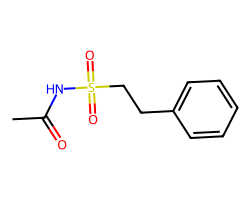

This is Molecule 1


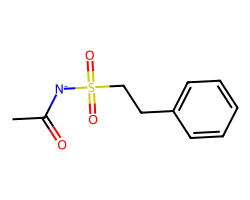

In [11]:
#@title Input molecule
#@markdown Please provide molecule SMILES. We will generate its protonation
#@markdown states.
# As a two state example we will use SM-26 from SAMP7 challenge
# (https://github.com/samplchallenges/SAMPL7/tree/master/physical_property)
# SMILES: O=S(CCC1=CC=CC=C1)(NC(C)=O)=O
# pKa = 4.91
# (https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.pdf)
smiles = "O=S(CCC1=CC=CC=C1)(NC(C)=O)=O" #@param {type: "string"}
dimorphite_dl = DimorphiteDL(
    min_ph=1,
    max_ph=13,
    max_variants=256,
    label_states=False,
    pka_precision=0.1
)
mols = [Chem.MolFromSmiles(mol) for mol in dimorphite_dl.protonate(smiles)]
mols = sorted(mols, key = lambda x: Chem.GetFormalCharge(x), reverse=True)
# Now mols[0] is the highest protonation state
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [31]:
#@title Select molecules
#@markdown Which molecule states do you want to use?
#@markdown The molecule ids are shown in the previous cell.
mol1 = True #@param {type:"boolean"}
mol2 = True #@param {type:"boolean"}
mol3 = False #@param {type:"boolean"}
mol4 = False #@param {type:"boolean"}
mol5 = False #@param {type:"boolean"}
mol6 = False #@param {type:"boolean"}
mol7 = False #@param {type:"boolean"}
mol8 = False #@param {type:"boolean"}
mol9 = False #@param {type:"boolean"}
mol10 = False #@param {type:"boolean"}

mols_to_use = [
    mol1, mol2, mol3, mol4, mol5, mol6, mol7, mol8, mol9, mol10,
][:len(mols)]

mols = [mols[i] for i in range(len(mols)) if mols_to_use[i]]

This is Molecule 0


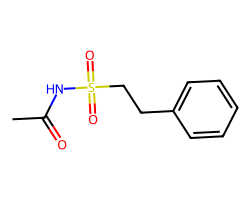

This is Molecule 1


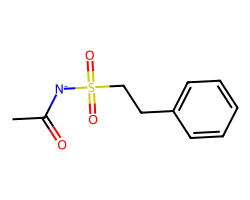

In [32]:
#@title Selected molecules
#@markdown The foloweing molecules will be used in the furhter analysis.
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [33]:
#@title Get titratable site
# Highest protonation state is always in state[0]
titratable_sites = []
pmol = mols[0]
for m in mols[1:]:
    from rdkit.Chem import rdFMCS
    res = rdFMCS.FindMCS([pmol, pmol])
    similar_patt = Chem.MolFromSmarts(res.smartsString)
    subst_matches_pmol = pmol.GetSubstructMatches(similar_patt)[0]
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    for a0, a in zip(subst_matches_pmol, subst_matches):
        if (pmol.GetAtomWithIdx(a0).GetFormalCharge() !=
            m.GetAtomWithIdx(a).GetFormalCharge()
        ):
            titratable_sites.append(a0)
titratable_sites = list(set(titratable_sites))

In [34]:
titratable_sites

[3]

In [35]:
#@title Get list of symmetrical titratable sites
from rdkit.Chem import rdFMCS
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
subst_matches = pmol.GetSubstructMatches(similar_patt, uniquify=False)
print(subst_matches)
symmetrical_sites = {x.GetIdx():[x.GetIdx()] for x in pmol.GetAtoms()}
if len(subst_matches) > 1:
    for sm in subst_matches[1:]:
        for ts in titratable_sites:
            if sm[subst_matches_pmol.index(ts)] not in symmetrical_sites[ts]:
                symmetrical_sites[ts].append(sm[subst_matches_pmol.index(ts)])
                symmetrical_sites[sm[subst_matches_pmol.index(ts)]].append(ts)
symmetrical_sites

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 13, 12, 11, 10), (0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10, 11, 12, 13, 14), (0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 14, 13, 12, 11, 10))


{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13],
 14: [14]}

In [36]:
#@title Get list of sites with multiple hydrogens
sites_with_multiple_hs = []
for ts in titratable_sites:
    if (
        pmol.GetAtomWithIdx(ts).GetNumExplicitHs()
        + pmol.GetAtomWithIdx(ts).GetNumImplicitHs()
        > 1
    ):
        sites_with_multiple_hs.append(ts)
sites_with_multiple_hs

[]

In [37]:
#@title Highlight sites with multiple hydrogens
if sites_with_multiple_hs:
    print(
        f"We detected {len(sites_with_multiple_hs)} sites to which multiple "
        + "hydrogens are attached. Please, take a careful look and let us know "
        + "whether we should consider those sites as multisite with each "
        + "hydrogen titrating separately, or as single site, where only one "
        + "hydrogen is titrated. Note, that we highlight the titratable sites "
        + "for the molecule in the highest protonation state, The ."
    )
    colors = [(1.0, 0.0, 0.0, 0.2)]
    for i, a in enumerate(sites_with_multiple_hs):
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', str(i+1))
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    at_highlights = {x: [colors[0]] for x in sites_with_multiple_hs}
    at_rads = {x: 0.5 for x in sites_with_multiple_hs}
    d2d.DrawMoleculeWithHighlights(pmol,"", at_highlights,{}, at_rads, {})
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    for a in sites_with_multiple_hs:
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', '')
else:
    mHs = None
    print(
        "No sites to which multiple hydrogens are attached were detected. "
        + " You can skip the next step."
    )

No sites to which multiple hydrogens are attached were detected.  You can skip the next step.


In [ ]:
#@title Select treatment of multi-hydrogen sites
#@markdown Do you want to treat titratable sites with multiple hydrogens
#@markdown attached as single multisite or no? Default is no. If you want
#@markdown to treat those with multisite representation tick the corresponding
#@markdown variable. The id of titratable sites are shown in the previous cell.
multiHs_titratable_site_1 = True #@param {type:"boolean"}
multiHs_titratable_site_2 = False #@param {type:"boolean"}
multiHs_titratable_site_3 = False #@param {type:"boolean"}
multiHs_titratable_site_4 = False #@param {type:"boolean"}
multiHs_titratable_site_5 = False #@param {type:"boolean"}

mHs = [
    multiHs_titratable_site_1,
    multiHs_titratable_site_2,
    multiHs_titratable_site_3,
    multiHs_titratable_site_4,
    multiHs_titratable_site_5,
][:len(sites_with_multiple_hs)]

In [38]:
mHs

In [39]:
#@title Symmetrical states treatment
states = {}  # Dictionary of states and state treatment. Each state has a
# molecule, number of states and number of states for consideration
# NOTE: state treatment should be fixed/changed after user input is provided
for i, m in enumerate(mols):
    from rdkit.Chem import rdFMCS
    res = rdFMCS.FindMCS([pmol, pmol])
    similar_patt = Chem.MolFromSmarts(res.smartsString)
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    charges = {}
    for a in symmetrical_sites:
        charges[a] = [
            m.GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(a)]
            ).GetFormalCharge()
        ]
        if len(symmetrical_sites[a]) == 1:
            continue
        for idx in symmetrical_sites[a][1:]:
            charges[a].append(
                m.GetAtomWithIdx(
                    subst_matches[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            )
    if all([len(list(set(x))) == 1 for x in charges.values()]):
        states[i] = (m, 1, 1)
        continue
    print(f"For molecule {i} symmetrical states were detected:")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    print("These are found symmetrical states:")
    atoms_to_change = [x for x in charges if len(charges[x]) > 1]
    atoms_with_dif_charges = [
        x for x in charges if len(charges[x]) == 1 and
        charges[x][0] != pmol.GetAtomWithIdx(x).GetFormalCharge()
    ]
    charge_combinations = list(zip(*[charges[x] for x in atoms_to_change]))
    state_charges = []
    from copy import deepcopy
    for c in charge_combinations:
        m_new = deepcopy(pmol)
        for a in atoms_with_dif_charges:
            m_new.GetAtomWithIdx(a).SetFormalCharge(
                pmol.GetAtomWithIdx(a).GetFormalCharge() - 1
            )
            m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
            )
        for a_charge, a in zip(c, atoms_to_change):
            if a_charge != pmol.GetAtomWithIdx(a).GetFormalCharge():
                m_new.GetAtomWithIdx(a).SetFormalCharge(a_charge)
                m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                    pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
                )
        if [x.GetFormalCharge() for x in m_new.GetAtoms()] in state_charges:
            continue
        state_charges.append([x.GetFormalCharge() for x in m_new.GetAtoms()])
        d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
        colors = [(0.0, 1.0, 0.0, 0.2)]
        at_highlights = {x: [colors[0]] for x in atoms_to_change}
        at_rads = {x: 0.5 for x in atoms_to_change}
        d2d.DrawMoleculeWithHighlights(m_new,"", at_highlights,{}, at_rads, {})
        d2d.FinishDrawing()
        display(SVG(d2d.GetDrawingText()))
    states[i] = (m, len(state_charges), 1)
if all([x[1] == 1 for x in states.values()]):
    ss = None
    print(
        "No symmetrical states were found "
        + " You can skip the next step."
    )

No symmetrical states were found  You can skip the next step.


In [40]:
#@title Select treatment of symmetrical states
#@markdown Please, select whether to inclue symmetrical states for a molecule
#@markdown or not. If for a particular molecule there are no symmetrical
#@markdown states available, selecting True won't influence the behaviour
use_symmetrical_states_molecule_0 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_1 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_2 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_3 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_4 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_5 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_6 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_7 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_8 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_9 = False #@param {type:"boolean"}

ss = [
    use_symmetrical_states_molecule_0,
    use_symmetrical_states_molecule_1,
    use_symmetrical_states_molecule_2,
    use_symmetrical_states_molecule_3,
    use_symmetrical_states_molecule_4,
    use_symmetrical_states_molecule_5,
    use_symmetrical_states_molecule_6,
    use_symmetrical_states_molecule_7,
    use_symmetrical_states_molecule_8,
    use_symmetrical_states_molecule_9,
][:len(states)]

In [41]:
#@title Update states information
for i, s in zip(states.keys(), states.values()):
    if ss:
        t = ss[i]
    else:
        t = False
    if t:
        states[i] = (s[0], s[1], s[1])
    if mHs:
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches = s[0].GetSubstructMatches(similar_patt)[0]
        factor = 1
        for idx in sites_with_multiple_hs:
            if not mHs[sites_with_multiple_hs.index(idx)]:
                continue
            a = s[0].GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(idx)]
            )
            a_p = pmol.GetAtomWithIdx(idx)
            if (
                (a.GetNumExplicitHs() + a.GetNumImplicitHs()) !=
                (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
            ):
                factor *= (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
        states[i] = (s[0], s[1], states[i][1] * factor)
states

{0: (<rdkit.Chem.rdchem.Mol at 0x7f69ccde3ca0>, 1, 1),
 1: (<rdkit.Chem.rdchem.Mol at 0x7f69ccde3d10>, 1, 1)}

We found the following transitions between protonation states:
Transition 0


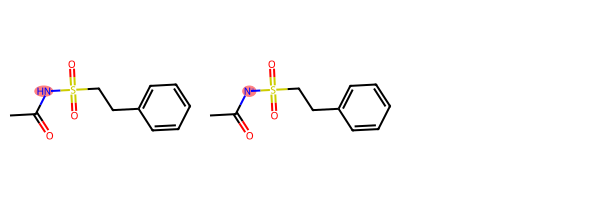

In [42]:
#@title Show state transitions
state_transitions = []
for i, m1 in enumerate(mols):
    for j, m2 in enumerate(mols[i+1:]):
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches1 = m1.GetSubstructMatches(similar_patt)[0]
        subst_matches2 = m2.GetSubstructMatches(similar_patt)[0]
        n_diffs = 0
        for idx in titratable_sites:
            if (
                m1.GetAtomWithIdx(
                    subst_matches1[subst_matches_pmol.index(idx)]
                ).GetFormalCharge() !=
                m2.GetAtomWithIdx(
                    subst_matches2[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            ):
                n_diffs += 1
        if n_diffs != 1:
            continue
        state_transitions.append((i, i + 1+j, m1, m2))

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    target_atm2 = []
    for a1, a2 in zip(match1, match2):
        if (
            mol1.GetAtomWithIdx(a1).GetFormalCharge() !=
            mol2.GetAtomWithIdx(a2).GetFormalCharge()
        ):
            target_atm1.append(a1)
            target_atm2.append(a2)
    d2d = Draw.MolsToGridImage(
        [mol1, mol2],
        highlightAtomLists=[target_atm1, target_atm2],
        useSVG = True,
    )
    display(d2d)

print("We found the following transitions between protonation states:")
for i, st_t in enumerate(state_transitions):
    print(f"Transition {i}")
    view_difference(st_t[2], st_t[3])

In [43]:
state_transitions

[(0,
  1,
  <rdkit.Chem.rdchem.Mol at 0x7f69ccde3d10>)]

In [44]:
#@title Provide pKa values for transitions between protonated states
#@markdown Please, provide pKa values for protonated states.
pka_0 = 4.91 #@param {type:"number"}
pka_1 = 5.0 #@param {type:"number"}
pka_2 = 7.0 #@param {type:"number"}
pka_3 = 6.0 #@param {type:"number"}
pka_4 = 0.0 #@param {type:"number"}
pka_5 = 0.0 #@param {type:"number"}
pka_6 = 0.0 #@param {type:"number"}
pka_7 = 0.0 #@param {type:"number"}
pka_8 = 0.0 #@param {type:"number"}
pka_9 = 0.0 #@param {type:"number"}

pkas = [
    pka_0, pka_1, pka_2, pka_3, pka_4,
    pka_5, pka_6, pka_7, pka_8, pka_9,
][:len(state_transitions)]

In [45]:
#@title Generate pKa matrix equation
import numpy as np
from sympy import Matrix, MatrixSymbol, symbols
if len(mols) == 2:
    print(f"Single state should be used. pKa = {pkas[0]}")
else:
    ph = symbols("pH")
    A = np.zeros((len(state_transitions) + 1, len(mols)), dtype = 'int')
    b = MatrixSymbol('b', len(state_transitions) + 1, 1).as_explicit()
    bsubs = {b[0,0]: ph}
    for i, (tr, pka) in enumerate(zip(state_transitions, pkas)):
        state1 = tr[0]
        state2 = tr[1]
        n = states[state1][2]
        m = states[state2][2]
        if Chem.GetFormalCharge(tr[2]) > Chem.GetFormalCharge(tr[3]):
            A[i+1, state1] =-1
            A[i+1, state2] = 1
            bsubs[b[i + 1, 0]] = pka - np.log10(n/m) - ph
        else:
            A[i+1, state1] = 1
            A[i+1, state2] = -1
            bsubs[b[i + 1, 0]] = pka - np.log10(m/n) - ph
    A[0, 0] = 1
    m = Matrix(A)
    _, inds = m.T.rref()
    removed_inds = [x for x in range(len(state_transitions) + 1) if x not in inds]
    Ar = A[list(inds)]
    Ad = A[list(removed_inds)]
    mr = Matrix(Ar)
    md = Matrix(Ad)
    p = MatrixSymbol('p', len(mols), 1).as_explicit()
    b = b.subs(bsubs)
    br = MatrixSymbol('br', len(inds), 1).as_explicit()
    brsubs = {}
    for i, idx in enumerate(inds):
        brsubs[br[i, 0]] = b[idx, 0]

    br = br.subs(brsubs)
    br

    sol = mr.solve(br)
    print(
        "Recommended pKa values for protonations states, considering all previous "
        + "input are:"
    )
    for i in range(len(mols)):
        print(f"State {i}: pKa = {sol[i,0]}")

Single state should be used. pKa = 4.91


In [52]:
#@title Topology and structure general behavior
#@markdown Do you want us to generate topology and molecule structure with
#@markdown Open Force Field? If no, you would need to provide topologies in
#@markdown **.itp** format in the following steps.
is_generation_needed = True #@param {type:"boolean"}
ff_to_use = "openff-2.1.0.offxml" #@param {type:"string"}

if is_generation_needed:
    ff = ForceField(ff_to_use)
    for _i, m in enumerate(mols):
        _m = Molecule.from_rdkit(m)
        _m.generate_conformers()
        interchange = ff.create_interchange(_m.to_topology())
        if _i == 0:
            interchange.to_gromacs(f"molecule_{_i}")
        else:
            interchange.to_top(f"molecule_{_i}.top")

This is Molecule 0


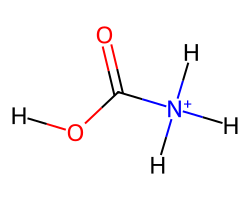

This is Molecule 1


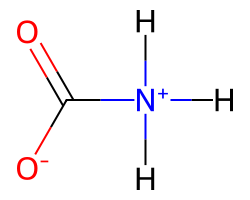

In [ ]:
#@title Provide topologies data
#@markdown If parameterisation is needed, all included molecules will be
#@markdown parameterized with open force field. If not, for all
is_parameterisation_needed = True #@param {type:"boolean"}
included_mols = [m for m,i in zip(mols, incl) if i]
included_svgs = [s for s,i in zip(svgs, incl) if i]
for i, s in enumerate(included_svgs):
    print(f"This is Molecule {i}")
    display(SVG(svgs[i]))

parameters_for_molecule_0 = "" #@param {type:"string"}
parameters_for_molecule_1 = "" #@param {type:"string"}
parameters_for_molecule_2 = "" #@param {type:"string"}
parameters_for_molecule_3 = "" #@param {type:"string"}
parameters_for_molecule_4 = "" #@param {type:"string"}

In [29]:
from openff.interchange import Interchange

In [ ]:
inter = Interchange.from_smirnoff(force_field=ff, topology=top)

In [ ]:
inter.to_top("test.top")